# TDVP numerical test \#1

The goal is to use the TDVP to simulate the time evolution of a simple Hamiltonian, when state space is restricted to some manifold Furthermore a goal is to compare this method with directly solving the SE and projecting to the manifold.

The first example will be $\mathcal{M}= S^2$ and $H=\sigma_x$ to generate an X-rotation of a 1-qubit system. Note that the Bloch-sphere is a restriction of the entire 2-dim $\mathcal{H}$ onto a sphere. 

In [31]:
from math import * 
import numpy as np
import scipy as sp
import mayavi
import matplotlib.pyplot as plt

import qutip as qt

from itertools import combinations
from typing import Iterable, Callable

In [32]:
def psi(pars:Iterable[float])->qt.qobj.Qobj:
    
    return np.cos(pars[0]/2)*qt.basis(2,0)+np.exp(1j*pars[1])*np.sin(pars[0]/2)*qt.basis(2,1)

In [33]:
def finitediff(func:Callable[[Iterable[float]],qt.Qobj],epsilon:float=1e-10)->Callable[[Iterable[float]],qt.Qobj]:
    def dfunc(params):
        difference = list()
        for i in range(2):
            p_params = list(params)
            p_params[i]+=epsilon
            difference.append((func(p_params)-func(params))/epsilon)
        return difference
    return dfunc
    

In [34]:
df = finitediff(psi)

In [35]:
df((1,1))

[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.23971269+0.j       ]
  [ 0.23708036+0.3692302j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[ 0.        +0.j        ]
  [-0.40342285+0.25903446j]]]

In [36]:
def G(psi:Callable[[Iterable[float]],qt.Qobj],pars:Iterable[float])->np.matrix:
    dpsi = finitediff(psi)
    return np.matrix([[
        (dpsi(pars)[j].dag()*dpsi(pars)[k]).full()[0][0]
        for k in range(2)] for j in range(2)]) # order of j,k must be correct -> j should be rows, k should be columns


In [37]:
def grad(psi:Callable[[Iterable[float]],qt.Qobj], pars:Iterable[float],H:qt.Qobj=qt.sigmax())->np.matrix:
    dpsi = finitediff(psi)
    out = np.matrix([
        (dpsi(pars)[k].dag()*H*psi(pars)).full()[0][0]
        for k in range(2)]).T

    return out

In [38]:
def G_man(psi,pars: Iterable[float]) -> np.matrix:
    th,ph = pars
    return np.matrix([[1/4*(np.sin(th/2)**2 + np.exp(1j*2*ph)*np.cos(th/2)**2), (1j*np.exp(1j*ph)-1)*np.sin(th)],
                      [(1j*np.exp(1j*ph)-1)*np.sin(th), np.cos(th/2)**2 - np.exp(1j*2*ph)*np.sin(th/2)**2]])


In [39]:
def grad_man(psi,pars:Iterable[float],H:qt.Qobj=qt.sigmax()):
    # for sigmax()
    th, ph = pars
    return np.matrix([1/2*np.exp(-1j*ph)*(np.cos(th/2)**2 - 1j*np.exp(1j*ph)*np.sin(th/2)*np.cos(th/2)),
    1/2*(1+1j)*np.exp(1j*ph)*np.sin(th)]).T

In [40]:
np.linalg.inv(G_man(psi,(.1,0)))*grad_man(psi,(.1,0))

matrix([[2.01413742-0.26123435j],
        [0.22604429-0.17813134j]])

In [41]:
grad(psi,(0,0))

matrix([[0.5+0.j],
        [0. +0.j]])

In [42]:
np.matrix([
        str(k)
        for k in range(2)]).T

matrix([['0'],
        ['1']], dtype='<U1')

In [43]:
grad_man(psi, (0,0))

matrix([[0.5+0.j],
        [0. +0.j]])

In [44]:
grad(psi,(0,0))

matrix([[0.5+0.j],
        [0. +0.j]])

In [45]:
np.linalg.inv(G(psi,[1,0]))

matrix([[17.40275211 +0.j        ,  0.        -15.92776002j],
        [ 0.        +15.92776002j, 18.92846804 +0.j        ]])

In [46]:
np.imag(1j*G(psi,[0.1,0])*grad(psi,[.1,0],qt.sigmay()))

matrix([[0.        ],
        [0.01260387]])

In [47]:
np.linalg.inv(np.imag(G(psi,(.1,0)))) == np.imag(np.linalg.inv(G(psi,(.1,0))))

matrix([[ True, False],
        [False,  True]])

In [70]:
def linear_evo(psi:Callable[[Iterable[float]],qt.Qobj],par_0:Iterable[float],H:qt.Qobj=qt.sigmax(),stepsize:float=.5,steps:int=1000):
    par_list = [par_0]
    for t in range(steps):
        par = par_list[-1]
        new_par = (
            np.matrix([par]) - stepsize * np.linalg.inv(np.imag(G(psi,par))) * np.real(grad(psi,par,H))
        ).tolist()[0]
        # new_par=np.real_if_close(new_par,tol=1)
        assert np.isrealobj(new_par), f"imaginary part to large: {np.abs(np.imag(new_par)/np.real(new_par))} %"
        # new_par=np.real(new_par)
        par_list.append(tuple(new_par))
        
    return par_list
    

In [72]:
pts = linear_evo(psi,(0.1,0), H=qt.sigmay(), steps=50, stepsize=.1)

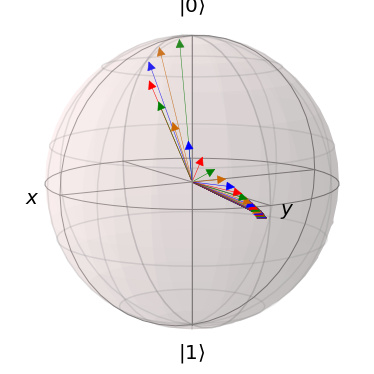

In [73]:
b = qt.Bloch()
b.add_states([psi(pt) for pt in pts],kind="vector")
b.view=[-30,10]
b.vector_width=.5
b.show()

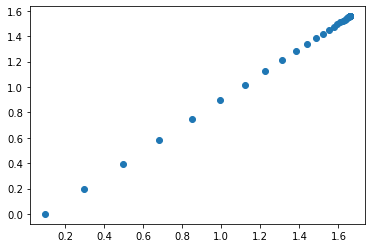

In [80]:
x = [x for (x,y) in pts]
y = [y for (x,y) in pts]
plt.scatter(x,y)

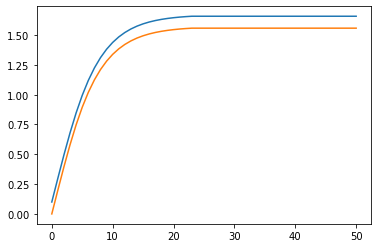

In [76]:
plt.plot(pts)

In [77]:
tlist = np.linspace(0,2,40)

In [78]:
result = qt.sesolve(qt.sigmay(),psi((0.1,0)),tlist=tlist)

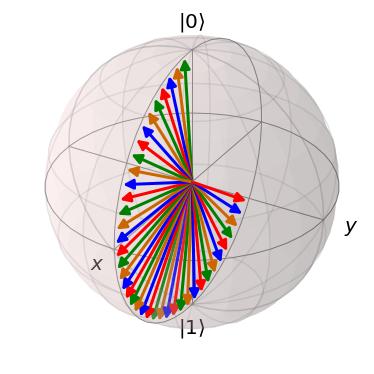

In [79]:
bbb = qt.Bloch()
bbb.add_states(result.states)
bbb.show()